In [1]:
import torch

In [2]:
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image
import torchvision.transforms as tt

from transform_helper import Rescale, ToTensor
from mobilenetv2_model import MobileNetV2

In [3]:
train_tfms = tt.Compose([#tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         # Настройки для расширения датасета
                         #tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.Resize((64,64)),
                         #tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

glasses_dataset = ImageFolder('dataset', train_tfms)

In [17]:
train_loader = DataLoader(glasses_dataset, batch_size=1,
shuffle=True, num_workers=4, pin_memory=True)

In [18]:
net = MobileNetV2(n_class=2, input_size=64).to('cuda')

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 64, 64])


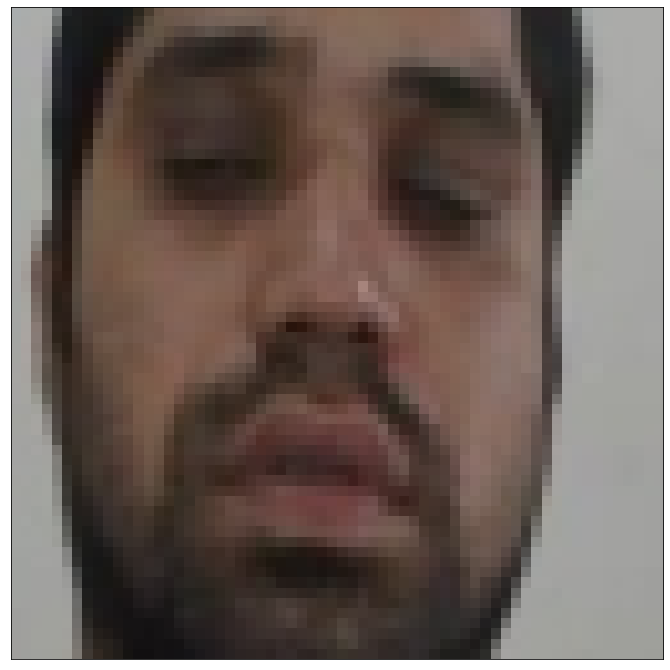

In [20]:
show_batch(train_loader)

In [ ]:
epoch_losses = []

epochs = 24
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(net.parameters(), max_lr, weight_decay=weight_decay)

for epoch in range(epochs):  # 10 эпох 
    running_loss = 0.0 # Для вывода процесса обучения
    epoch_loss = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to('cuda'), data[1].to('cuda')

        # Обнуляем градиент
        optimizer.zero_grad()

        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss =  F.cross_entropy(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    epoch_losses.append(epoch_loss)

print('Training is finished!')

[1,     1] loss: 0.000
[1,   301] loss: 0.246
[1,   601] loss: 0.108
[1,   901] loss: 0.105
[1,  1201] loss: 0.105
[1,  1501] loss: 0.104
[1,  1801] loss: 0.105
[1,  2101] loss: 0.104
[1,  2401] loss: 0.104
[1,  2701] loss: 0.105
[1,  3001] loss: 0.104
[1,  3301] loss: 0.103


Text(0.5, 1.0, 'losses vs. No. of epochs')

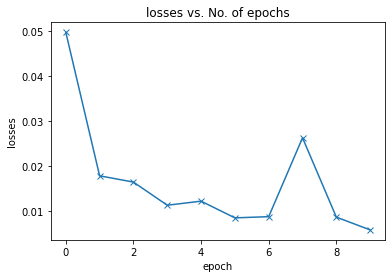

In [14]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [15]:
torch.save(net.state_dict(), './saved_models/glasses_classifier_10epoch_32batch.pth')

In [55]:
import cv2
import dlib
import imutils
import tensorflow as tf
import numpy as np

dlib.cuda.set_device(0)
print(dlib.cuda.get_device())

net=net(n_class=2, input_size=64).to('cuda')
net.load_state_dict(torch.load('./saved_models/glasses_classifier_10epoch_2model.pth'))
net.eval()

ModuleNotFoundError: No module named 'dlib'